# Workbook 6: Supervised Machine Learning

Overview of activities and objectives of this workbook:

1. The first part of this workbook will introduce the K Nearest Neighbour algorithm for supervised learning.
    - We will use the Iris dataset we introduced in the previous week.
    - You are provided code for 1NN (1 nearest neighbour) and will extend this, using generative AI, to KNN (k nearest neighbours).
    - We will also introduce several common Sklearn functions for splitting data into training and test sets, and visualising the results of classifiers.

2. The second part of this workbook will introduce Decision Trees, another supervised learning algorithm.
    - We will use the Sklearn implementation and explore how to limit tree growth (number/depth of branches) to prevent overfitting.

<div style="background-color:black;width:100%;"></div>

# Part 1: K nearest neighbours (KNN) <img src="figures/Iris-image.png" style="float:right">

First we will load the Iris data. This is a classic Machine Learning Data set which contains:
- 4 measurements (features): sepal and petal width and length
- 50 examples from each sub-species for iris flowers (so, 150 total)
- 3 class labels: Iris-Virginica, Iris-Setosa or Iris-Versicolor

The next cell to imports some useful libraries and then loads the iris dataset into two arrays:
- <code>irisX</code> (the features - 150 rows x 4 columns)
- <code>irisy</code> (the class labels - For the purpose of this tutorial we are going to ignore the fact that we are provided with class labels)
- We'll also make a list of the <code>feature_names</code> so we can use them to label our plots.
- Then we'll make a scatter plot to visualise the data.

Iris has 150 samples and 4 features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Iris has 3 classes: ['setosa' 'versicolor' 'virginica']


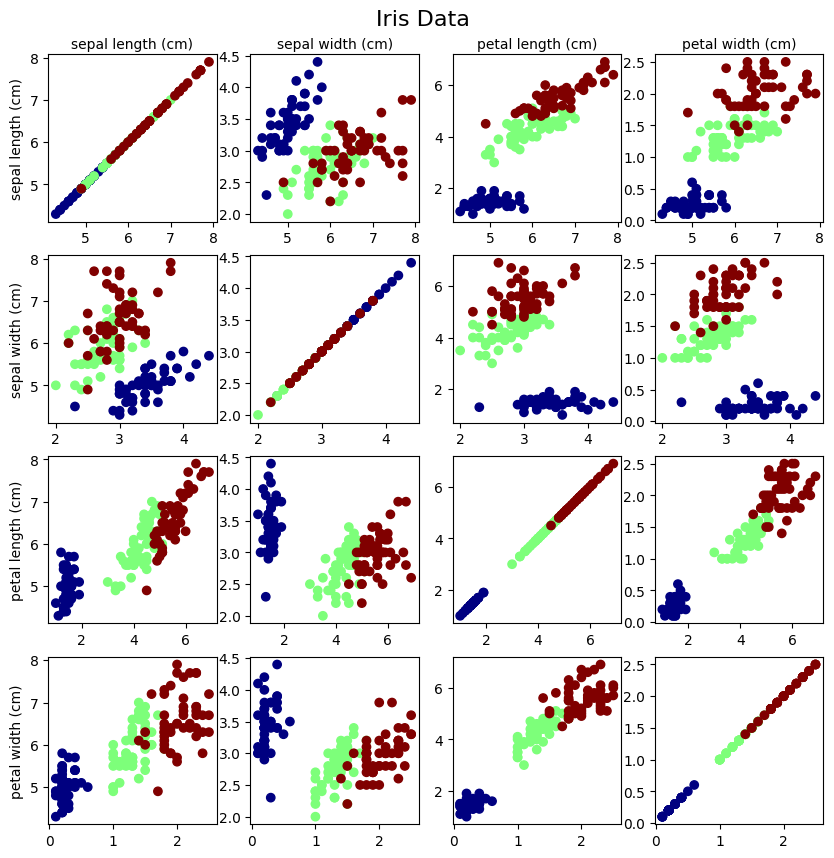

In [1]:
# load the data
import week6_utils as w6utils
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np

# Load the Iris data
iris_data = load_iris(return_X_y=False)
# Extract the data and labels, feature names, and label names
irisX = iris_data.data
irisy = iris_data.target
feature_names = iris_data.feature_names
label_names = iris_data.target_names

print(f"Iris has {irisX.shape[0]} samples and {irisX.shape[1]} features: {feature_names}")
print(f"Iris has 3 classes: {label_names}")

# Create a scatter plot of all the Iris data
w6utils.show_scatterplot_matrix(irisX, irisy, feature_names, "Iris Data")

## Implementing K-Nearest Neighbours

Implementations of supervised ML algorithms typically have two functions `fit()` and `predict()`.

**'Fitting'** -  means building/training the model with the training data, so that it (hopefully) makes good predictions.
   - With KNN this just means storing the training data.
   - But as we will see in future weeks this can also mean updating the model itself based on the quality of its predictions (e.g. with artificial neural networks).

**Predicting** - means using the model to make predictions e.g. the class of a particular data example.

For KNN predicting the label of a new example from the test set:
1. Measure distance to example point from every member of the training set.
2. Find the K Nearest Neighbours.  
   - In other words, the K members of the training set with the smallest distances (*calculated in step 1*)
3. Count the labels of those K training items and return the most common one as the predicted label.

Below is a figure illustrating the start and first two steps of process.  
It is followed by a code cell with a simple implementation of a class for 1-Nearest neighbours i.e. only consider the 1 closest neighbour. 

<b>Read through the code  to get a sense for how it implements the algorithm.</b><br>
Your tutor will discuss it with you in the lab sessions.
<img src="figures/kNN-steps.png">


<div class="alert alert-block alert-warning" style="color:black">
<b>Enumerating lists with python</b><br>
Quite often we may want to go through every item in a list and know:
<ul>
    <li> What the item is</li>
    <li> what position it is in (index)</li>
</ul>
We can do this in fewer lines of code by using python's built-in <code>enumerate</code> function.<br>
For example, this code snippet:<br>
<pre><code>my_list = ('a', 'b', 'c')
for idx, name in enumerate(my_list):
    print(idx , name)</code></pre>
produces the output:<br>
0 a<br>
1 b<br>
2 c<br>
</div>

In [2]:
class Simple1NNClassifier:
    """ Simple example class for 1-Nearest Neighbours algorithm.
    Assumes numpy is imported as np and uses euclidean distance
    """    
    def dist_a_b(self, a:np.array, b:np.array)->float:
        """ euclidean distance between same-size vectors a and b"""
        assert a.shape==b.shape, 'vectors not same size calculating distance'
        return np.linalg.norm(a-b) 
    
    def fit(self, x:np.ndarray, y:np.array):
        """ just stores the data for k-nearest neighbour"""
        self.model_x = x
        self.model_y = y
        self.is_fitted_=True
        
    def predict(self, new_items:np.ndarray):
        """ makes predictions for an array of new items"""

        # First item in  a numpy array's shape  is the number of rows
        # Get the number of new items and the number of stored items
        num_new = new_items.shape[0]
        num_stored = self.model_x.shape[0]
        
        # Create empty array to store predictions
        y_pred = np.zeros(num_new, dtype=int)
        
        # Measure distances - creates an array with one row for each new item and one column for each stored training example
        distances = np.zeros((num_new, num_stored))
        for row, new_item in enumerate(new_items):
            for col, stored_example in enumerate(self.model_x):
                distances[row][col]= self.dist_a_b(new_item, stored_example)

        # Make predictions - for each new example, find the stored example with the smallest distance
        for item_idx in range(num_new):
            y_pred[item_idx] = self.predict_one(item_idx, distances)
        
        # Return the predictions
        return y_pred
    
    def predict_one(self, item_idx:int, distances:np.ndarray):
        """ makes a class prediction for a single new item
        This version is just for 1 Nearest Neighbour

        Parameters
        ----------
        item_idx: int
            index of item to make prediction for - i.e. idx of row in distances matrix

        distances: numpy ndarray
            array of distances between new items (rows) and training set records (columns)
        """
        # We're going to use numpy's argmin() method
        # which gives us the get indexes of column with lowest value in an array
        idx_of_nearest_neighbour = np.argmin(distances[item_idx])

        # Return the predicted class of the nearest neighbour
        return self.model_y[ idx_of_nearest_neighbour]

## Applying 1NN to the Iris data

We'll use the simple 1NN (K=1) classifier defined above and train and test on the Iris data we loaded previously.

The next few cells demonstrate how to do this using some Sklearn functions/classes.

### Split the data into train and test sets
- `test_size` argument specifies how much of the data to keep back for testing (0.33 for the iris data is 50 for testing and 100 for training).
- `stratify` argument makes sure our data has the same proportions of classes in train and test set (1:1:1 for the iris data set as this is *balanced*).

In [3]:
# Make train/test split of datasets
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(irisX, irisy, test_size=0.33, stratify=irisy)

print(f'Training set has {train_x.shape[0]} examples, test set has {test_x.shape[0]} examples')

Training set has 100 examples, test set has 50 examples


### Create an instance of the model class then *fit*  it to the training data

In [4]:
my_1NN_model = Simple1NNClassifier()
my_1NN_model.fit(train_x, train_y)

### Evaluate the trained model's performance on unseen test data

In [5]:
# Make predictions for test data
predictions = my_1NN_model.predict(test_x)
print(f'Predictions are:\n {predictions}')

# Make array of True/False values for each prediction
# By comparing the predictions to the actual label values
print(f'Prediction matches to actual label values are:\n{test_y==predictions}')

# Calculate the accuracy
accuracy = 100 * (test_y == predictions).sum() / test_y.shape[0]
print(f"\nOverall Accuracy = {accuracy:.2f} %")

Predictions are:
 [0 2 1 1 1 2 0 0 0 1 1 2 2 0 1 2 2 0 1 1 0 2 1 1 0 1 2 1 2 0 0 2 0 0 2 2 1
 0 2 2 1 0 2 0 1 1 1 0 2 1]
Prediction matches to actual label values are:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]

Overall Accuracy = 98.00 %


### Visualise a confusion matrix
A confusion matrix shows the counts of predictions vs the true label for each example. So correct predictions appear on the diagonal.

This is often more useful than just calculating accuracy because it shows where the classifier is making mistakes.

The Iris data is quite easy, so most models will make correct predictions for *setosa*  
but misclassify one or two instances of *versicolor* and *virginica*.

[]

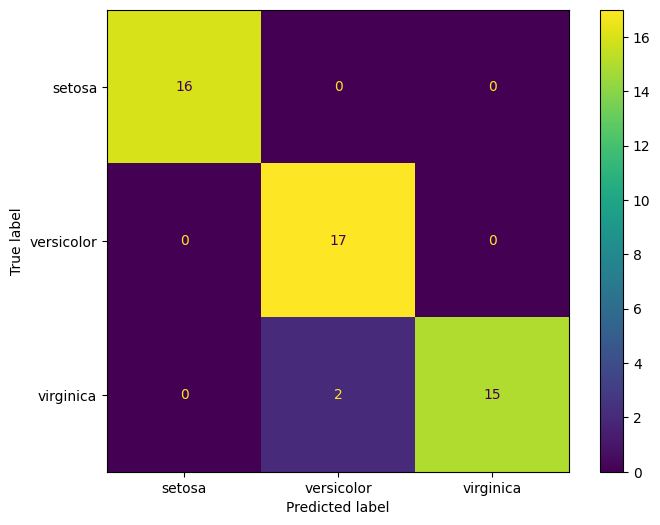

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(test_y, predictions, display_labels=label_names)
disp.figure_.set_size_inches(8, 6)
plt.plot()

### Visualise the decision boundary

The decision boundary shows how, within the 'decision space' the model is making predictions.

This can be useful to compare how different algorithms make decisions but is hard for most people to recognise in more than 2 dimensions.

So we will quickly train a model using a 2D version of the iris data set (just the petal measurements).


Overall Accuracy in 2D = 66.0%, model makes 17 mistakes


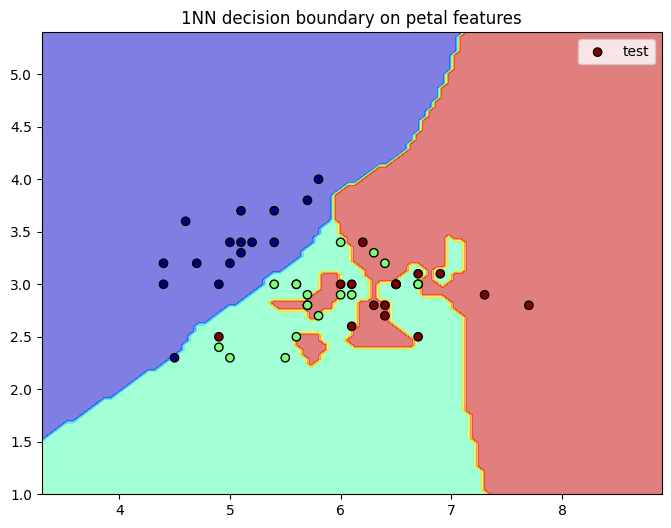

In [53]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

# Make data using numpy slicing to just pull the last two columns for every row
petal_trainx = train_x[:, :2]
petal_testx = test_x[:, :2]

# Instantiate and fit model to data
my_1NN_2d = KNeighborsClassifier(n_neighbors=1)
my_1NN_2d.fit(petal_trainx, train_y)

# Make predictions, score them 
y_pred = my_1NN_2d.predict(petal_testx)
accuracy = 100 * ( test_y == y_pred).sum() / test_y.shape[0]
num_errors= len(y_pred) - (test_y == y_pred).sum()
print(f"Overall Accuracy in 2D = {accuracy}%, model makes {num_errors} mistakes")

# Create the decision boundary learned by model from training data
disp = DecisionBoundaryDisplay.from_estimator(my_1NN_2d, petal_trainx, alpha=0.5)

# # Show where the test is within the decision boundary
disp.ax_.scatter(petal_testx[:, 0], petal_testx[:, 1], c=test_y, edgecolor='black', label='test')
_= disp.ax_.set_title("1NN decision boundary on petal features")
disp.figure_.set_size_inches(8, 6)
plt.show()

<div class="alert alert-block alert-info" style="color:black"><h2>Activity 1: Complete K-nearest neighbours with GenAI</h2>
    The <code>Simple1NNClassifier()</code> class above only implements KNN for K=1, i.e. only considers the single closest neighbour when making predictions. In this activity you will extend (via inheritance) the <code>Simple1NNClassifier()</code> into a full KNN classifier. In other words, to make a predictions for a new example: finds the K nearest neighbours and assigns the label of the most common class amongst the neighbours.<br><br>
    You need to complete the <code>SimpleKNNClassifier()</code> class below by:
    <ol>
        <li>Over-riding the <code>def __init__()</code> to take one parameter <code>K</code>, the number of neighbours to consider</li>
        <li>Over-riding the <code>predict_one()</code> method so that:
            <ol>
                <li>Finds the indexes of the <code>self.K</code> nearest neighbours from the <code>distances</code> array.<li>Stores the labels of these neighbours.</li>
                <li>Finds the most common label within the neighbours.</li>
                <li>Returns the most common label as the prediction for the new example.</li>
            </ol>
        </li>
    </ol>
    There are lots of different ways to implement this functionality in Python. For this activity it is suggested you use <b>Generative AI</b> tools to complete the <code>predict_one()</code> method (unless you prefer to code it yourself!). <br><br>
    The next cell below lets you test your KNN implementation with K=1 on the Iris data. You should find it reaches the same accuracy as the <code>Simple1NNClassifier()</code>. Then in the following activity we will think about how to test your implementation to verify it is correct.
</div>

<div class="alert alert-block alert-success" style="color:black"><b>Hints:</b> 
    <ul>
        <li>If you choose to use a GenAI tool with a text/web interface, like ChatGPT or Gemini, you should think carefully about how you construct the prompt. You aren't asking for a full KNN implementation, only a function that makes predictions for 1 new example, so:
            <ul>
                <li>Specify the parameters the function takes.</li>
                <li>What the output should be.</li>
            </ul>
        </li>
        <li>If you choose to use Github Copilot (or similar), you might find it easier to start typing the function definition (<code>def predict_one()</code>) and see if it provides a completion suggestion.
            <ul><li>Or, see if you can get copilot to help you complete each step above individually.</li></ul>
        </li>
    </ul>
</div>

In [55]:
class SimpleKNNClassifier(Simple1NNClassifier):
    """Complete this class to produce a KNN classifier"""
    
    # def __init__(self):
    #     """ Constructor for the KNN classifier
    #     you will need to change the function signature to expect and store a parameter K
    #     """
    #     raise NotImplementedError("Complete the function")

    # def predict_one(self, item_idx:int, distances:np.ndarray):
    #     """ makes a class prediction for a single new item
    #     This version is for K Nearest Neighbour

    #     Parameters
    #     ----------
    #     item_idx: int
    #         index of item to make prediction for - i.e. idx of row in distances matrix

    #     distances: numpy ndarray
    #         array of distances between new items (rows) and training set records (columns)
    #     """
    #     # ====> insert your code below here

    #     raise NotImplementedError("Complete the function")
        
    #     # <==== insert your code above here

    def __init__(self, K:int):
        """
        Constructor for the KNN classifier
        """
        self.K = K

    def predict_one(self, item_idx:int, distances:np.ndarray):
        """ makes a class prediction for a single new item
        This version is for K Nearest Neighbour

        Parameters
        ----------
        item_idx: int
            index of item to make prediction for - i.e. idx of row in distances matrix

        distances: numpy ndarray
            array of distances between new items (rows) and training set records (columns)
        """
        # Pair distances with labels and sort by distance
        distance_label_pairs = list(zip(distances[item_idx], self.model_y))
        distance_label_pairs.sort(key=lambda x: x[0])
        
        # Select the top k nearest neighbors
        nearest_neighbors = distance_label_pairs[:self.K]
        
        # Extract the labels of the nearest neighbors
        nearest_labels = [label for _, label in nearest_neighbors]

        # Count the number of occurrences of each label
        label_counts = np.bincount(nearest_labels)

        # Return the most common label
        return np.argmax(label_counts)

In [9]:
# Initialize the model with K=1
my_KNN_model = SimpleKNNClassifier(K=1)

# Fit the model to the training data
my_KNN_model.fit(train_x, train_y)

# Make predictions for test data
predictions = my_KNN_model.predict(test_x)
print(f'Predictions are:\n {predictions}')

# Calculate the accuracy
accuracy = 100 * (test_y == predictions).sum() / test_y.shape[0]
print(f"\nOverall Accuracy = {accuracy:.2f} %")

Predictions are:
 [0 2 1 1 1 2 0 0 0 1 1 2 2 0 1 2 2 0 1 1 0 2 1 1 0 1 2 1 2 0 0 2 0 0 2 2 1
 0 2 2 1 0 2 0 1 1 1 0 2 1]

Overall Accuracy = 98.00 %


<div class="alert alert-block alert-info" style="color:black"><h2>Activity 2: Evaluating KNN and GenAI</h2>
    Generative AI is very powerful and can save us a lot of time by helping to write code. However, you <b>should not blindly trust any code (or any thing) GenAI creates</b>. GenAI doesn't really <i>'understand'</i> what we are asking it to do. It is simply generating text/code/images based on its <i>prediction</i> of what is most likely correct. This does not mean it is correct, and sometimes it will <i>'hallucinate'</i>, i.e. make stuff up!<br>
    So you should always <i>verify</i> anything you ask GenAI to create. For code this should come from your understanding of the code it has generated and the algorithm. But for a more concrete test we can also write some test cases to check the output is correct.<br><br>
    Your <code>SimpleKNNClassifier()</code> with <code>K=1</code> should reach the same accuracy as the previous <code>Simple1NNClassifier()</code> did. But we should check it works for other values of K and also on other data.<br>
    Complete the following 3 cells to implement 3 different test cases and evaluate your GenAI version of KNN:
    <ol>
        <li>Compare with the Sklearn implementation of KNN on Iris data. In this case, we know the Sklearn KNN classifier is correct. So we can compare the Sklearn KNN predictions with our own implementation:
            <ul>
                <li>Create an instance of <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">Sklearn kNeighboursClassifier</a> and run it on the Iris data to make predictions.</li>
                <li>Create an instance of your <code>SimpleKNNClassifier()</code> and run it on the Iris data to make predictions.</li>
                <li>Compare Sklearn and your classifier predictions accuracy on different values of K.</li>
            </ul>
        </li>
        <li>Compare with the Sklearn implementation of KNN on random data. This is the same as step 1, except instead of Iris data we will randomly generate some.
            <ul>
                <li>Use the <a href="https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.make_multilabel_classification.html#sklearn.datasets.make_multilabel_classification">Sklearn make_multilabel_classification()</a> function to create a dataset with  500 samples, 2 features and 4 classes. Or experiment with different numbers of features/classes.</li>
                <li>Compare Sklearn and your classifier as before.</li>
            </ul>
        </li>
        <li>Construct simple 2D data to test KNN. We can manually construct data that will give different predictions for different values of K, e.g. K=1 predict 0, K=3 predict 1, K=5 predict 0 etc.
            <ul>
                <li>Create two 2D arrays of 5 examples (data points) each. One array for class 0 and one array for class 1.</li>
                <li>Test on a single example. Suggest you use <code>[4.1, 4.1]</code> but you can use another if you prefer!</li>
                <li>Compare Sklearn and your classifier as before. The predictions should be different for increasing values of K, e.g. <code>[1, 0, 1, 0, 1]</code> for k values <code>[1, 3, 5, 7, 9]</code> </li>
            </ul>
        </li>
    </ol>
</div>

Test 1: Compare with the Sklearn implementation of KNN on Iris data.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Test different values of K
for K in [1, 3, 5, 7, 9]:
    # ====> insert your code below here
    # Instantiate and fit Sklearn model to data
    skl_knn = KNeighborsClassifier(n_neighbors=K)
    skl_knn.fit(train_x, train_y)

    # Make predictions
    skl_knn_pred = skl_knn.predict(test_x)

    # Instantiate and fit your model to data
    my_knn = SimpleKNNClassifier(K=K)
    my_knn.fit(train_x, train_y)

    # Make predictions
    my_knn_pred = my_knn.predict(test_x)

    # Calculate the accuracy of both models
    skl_acc = 100 * (test_y == skl_knn_pred).sum() / test_y.shape[0]
    my_acc = 100 * (test_y == my_knn_pred).sum() / test_y.shape[0]

    # <==== insert your code above here
    print(f"Accuracy of Sklearn model is {skl_acc:.2f}%, your model is {my_acc:.2f}%")
    assert skl_acc == my_acc, f"Accuracy of Sklearn model is not the same asyour model for K={K}"

    # Compare individual predictions
    assert (skl_knn_pred == my_knn_pred).all(), "Predictions are not the same for K={K}"
    print(f"Sklearn and your model make the same predictions for K={K}\n")

Accuracy of Sklearn model is 98.00%, your model is 98.00%
Sklearn and your model make the same predictions for K=1

Accuracy of Sklearn model is 96.00%, your model is 96.00%
Sklearn and your model make the same predictions for K=3

Accuracy of Sklearn model is 100.00%, your model is 100.00%
Sklearn and your model make the same predictions for K=5

Accuracy of Sklearn model is 98.00%, your model is 98.00%
Sklearn and your model make the same predictions for K=7

Accuracy of Sklearn model is 98.00%, your model is 98.00%
Sklearn and your model make the same predictions for K=9



Test 2: Compare with the Sklearn implementation of KNN on random data

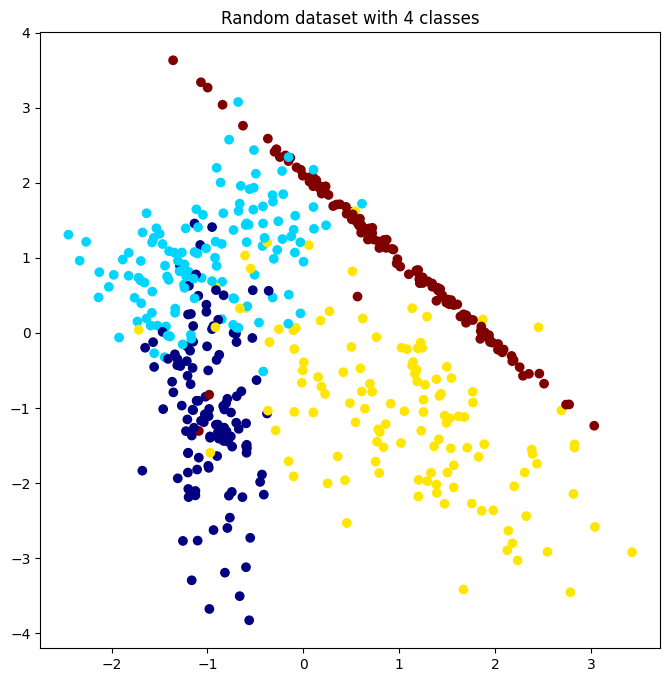

Accuracy of Sklearn model is 82.42%, your model is 82.42%
Sklearn and your model make the same predictions for K=1

Accuracy of Sklearn model is 85.45%, your model is 85.45%
Sklearn and your model make the same predictions for K=3

Accuracy of Sklearn model is 87.27%, your model is 87.27%
Sklearn and your model make the same predictions for K=5

Accuracy of Sklearn model is 82.42%, your model is 82.42%
Sklearn and your model make the same predictions for K=7

Accuracy of Sklearn model is 82.42%, your model is 82.42%
Sklearn and your model make the same predictions for K=9



In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

# Create a random dataset with 500 samples, 2 features and 4 classes
# ====> insert your code below here
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_classes=4, n_clusters_per_class=1)
# <==== insert your code above here

# Visualise the data
fig, an = plt.subplots(figsize=(8, 8))
an.scatter(X[:, 0], X[:, 1], c=y)
an.set_title("Random dataset with 4 classes")
plt.show()

# Create a train/test split of the data
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, stratify=y)

# Test different values of K
for K in [1, 3, 5, 7, 9]:
    # ====> insert your code below here

    # Instantiate and fit Sklearn model to data
    skl_knn = KNeighborsClassifier(n_neighbors=K)
    skl_knn.fit(train_x, train_y)

    # Make predictions
    skl_knn_pred = skl_knn.predict(test_x)

    # Instantiate and fit your model to data
    my_knn = SimpleKNNClassifier(K=K)
    my_knn.fit(train_x, train_y)

    # Make predictions
    my_knn_pred = my_knn.predict(test_x)

    # Calculate the accuracy of both models
    skl_acc = 100 * (test_y == skl_knn_pred).sum() / test_y.shape[0]
    my_acc = 100 * (test_y == my_knn_pred).sum() / test_y.shape[0]

    # <==== insert your code above here
    print(f"Accuracy of Sklearn model is {skl_acc:.2f}%, your model is {my_acc:.2f}%")
    assert skl_acc == my_acc, f"Accuracy of Sklearn model is not the same asyour model for K={K}"

    # Compare individual predictions
    assert (skl_knn_pred == my_knn_pred).all(), "Predictions are not the same for K={K}"
    print(f"Sklearn and your model make the same predictions for K={K}\n")

Test 3: Construct simple 2D data to test KNN

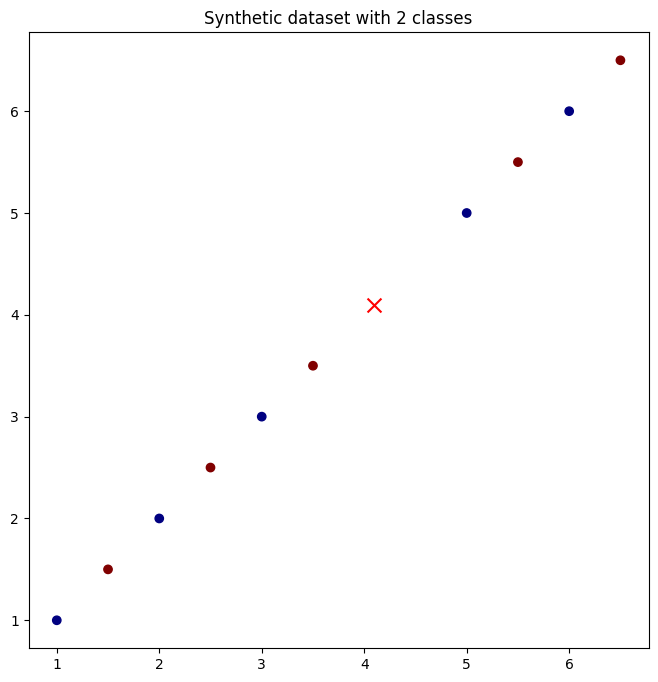

Sklearn and your model make the same predictions 1 and 1 for K=1

Sklearn and your model make the same predictions 0 and 0 for K=3

Sklearn and your model make the same predictions 1 and 1 for K=5

Sklearn and your model make the same predictions 0 and 0 for K=7

Sklearn and your model make the same predictions 1 and 1 for K=9

All predictions are as expected [1, 0, 1, 0, 1] for different values of K


In [41]:
from sklearn.neighbors import KNeighborsClassifier

# Generate synthetic 2D data with 5 examples in each class
# ====> insert your code below here
class_0 = np.array([[1, 1], [2, 2], [3, 3], [5, 5], [6, 6]])  # Class 0
class_1 = np.array([[1.5, 1.5], [2.5, 2.5], [3.5, 3.5], [5.5, 5.5], [6.5, 6.5]])  # Class 1
# <==== insert your code above here

# Combine data and labels
X = np.vstack((class_0, class_1))
y = [0] * len(class_0) + [1] * len(class_1)

# Test point
test_y = np.array([[4.1, 4.1]])

# Visualise the data
fig, an = plt.subplots(figsize=(8, 8))
an.scatter(X[:, 0], X[:, 1], c=y)
an.scatter(test_y[:, 0], test_y[:, 1], c='red', marker='x', s=100)
an.set_title("Synthetic dataset with 2 classes")
plt.show()

# Test different values of K
predictions = []
for K in [1, 3, 5, 7, 9]:
    # ====> insert your code below here

    # Instantiate and fit Sklearn model to data
    skl_knn = KNeighborsClassifier(n_neighbors=K)
    skl_knn.fit(X, y)

    # Make predictions
    skl_knn_pred = skl_knn.predict(test_y)

    # Instantiate and fit your model to data
    my_knn = SimpleKNNClassifier(K=K)
    my_knn.fit(X, y)

    # Make predictions
    my_knn_pred = my_knn.predict(test_y)

    # <==== insert your code above here
    assert skl_knn_pred == my_knn_pred, f"Prediction is not the same for K={K}"
    predictions.append(my_knn_pred[0].item())
    print(f"Sklearn and your model make the same predictions {my_knn_pred[0]} and {skl_knn_pred[0]} for K={K}\n")

# Check the predictions were different for different values of K
assert predictions == [1, 0, 1, 0, 1], "Predictions are not as expected"
print(f"All predictions are as expected {predictions} for different values of K")

<div class="alert alert-block alert-info" style="color:black"><h2>Activity 3: Experiment with KNN</h2>
Now that you have established that your implementation of KNN is correct, lets explore a few things that might effect its output predictions.

Creating different splits of the Iris data using  Sklearn's <code>train_test_split()</code> function:
    <ul>
        <li>Try changing the <code>random_state</code> parameter.</li>
        <li>Try removing the <code>stratify</code> parameter.</li>
        <li>Try changing the <code>test_size</code> parameter.</li>
        <li>Does it reach the same accuracy/predictions as before?</li>
        <li>If these are not the same, can you explain why not?</li>
    </ul>

In Machine Learning we talk about algorithms having <b>hyper-parameters</b> that control their behaviour. For KNN <code>K</code> is a <i>hyperparamter</i>. Try running and evaluating KNN with K = {3, 5, 7, 9}:
    <ul>
        <li>Make <b>qualitative</b> judgements: how does the decision surface change? (you might need to select 2 features as before).</li>
        <li>Make <b>quantitative</b> judgements:  how does the confusion matrix change?</li>
        <li>What value for the hyper-parameter <b>K</b> gives the best accuracy on the <b>train</b> set?</li>
        <li>What value for the hyper-parameter <b>K</b> gives the best accuracy on the <b>test</b> set?</li>
        <li>If these are not the same, can you explain why not?</li>
    </ul>
</div>

Training set has 100 examples, test set has 50 examples
Overall Accuracy for K=3 is 96.00%


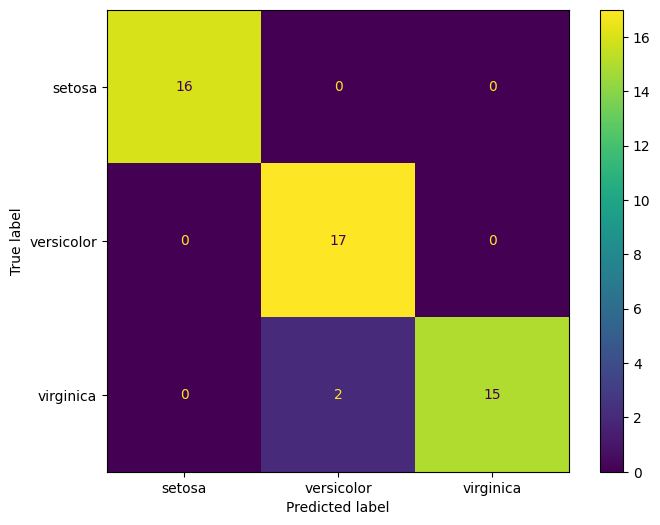

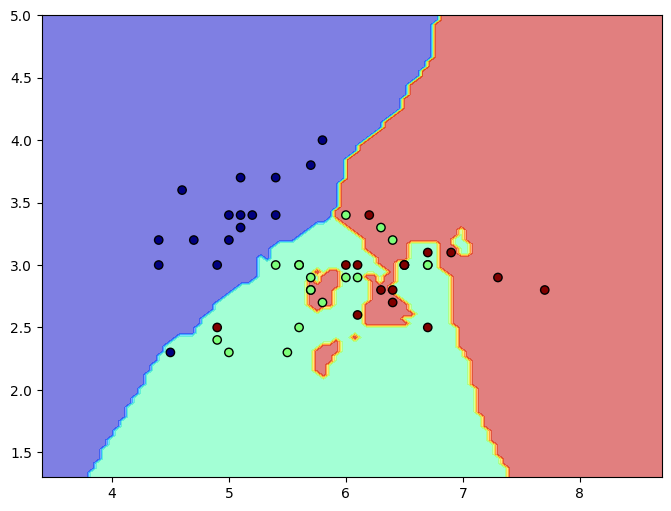

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Make train/test split of datasets
train_x, test_x, train_y, test_y = train_test_split(irisX, irisy, test_size=0.33, stratify=irisy, random_state=42)
print(f'Training set has {train_x.shape[0]} examples, test set has {test_x.shape[0]} examples')

# Set K
K = 3

# Instantiate and fit model to data
knn = SimpleKNNClassifier(K=K)
knn.fit(train_x, train_y)

# Make predictions
predictions = knn.predict(test_x)

# Calculate the accuracy
accuracy = 100 * (test_y == predictions).sum() / test_y.shape[0]
print(f"Overall Accuracy for K={K} is {accuracy:.2f}%")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(test_y, predictions, display_labels=label_names)
disp.figure_.set_size_inches(8, 6)
plt.plot()

# Create the decision boundary learned by model from training data
trainx_2_features = train_x[:, :2]
testx_2_features = test_x[:, :2]
knn_2d = KNeighborsClassifier(n_neighbors=K).fit(trainx_2_features, train_y)
disp = DecisionBoundaryDisplay.from_estimator(knn_2d, testx_2_features, alpha=0.5)
disp.ax_.scatter(petal_testx[:, 0], petal_testx[:, 1], c=test_y, edgecolor='black', label='test')
disp.figure_.set_size_inches(8, 6)
plt.show()


<div style="background-color:black;width:100%;"></div>

# Part 2: Decision Trees

In the lecture notebook we illustrated how the decision tree is created by dividing input space using a set of axis-parallel lines.

The tree is 'grown' by:
1. Start with single node that predicts majority class label.
2. Loop over every leaf node:
    - Measure (in some way) the "information content" of the data that arrives at that node.
    - For each possible data split:
        - measure and add the "information content" of the child nodes created by the split
        - subtract information content of parent
        - result is the *gain* in information content given by split
        - update stored "best split" if appropriate
    - If the  "best" split is above some threshold then change the leaf node to an interior node with the *best* condition.
    - If <i>termination criteria</i> not met goto step 2.

The following cells demonstrate how to create, train and evaluate a Decision Tree using Sklearn.

### Split the data into train and test sets

In [ ]:
# Make train/test split of datasets
train_x, test_x, train_y, test_y = train_test_split(irisX, irisy, test_size=0.33, stratify=irisy)
print(f'Training set has {train_x.shape[0]} examples, test set has {test_x.shape[0]} examples')

### Create an instance of the model class then *fit*  it to the training data

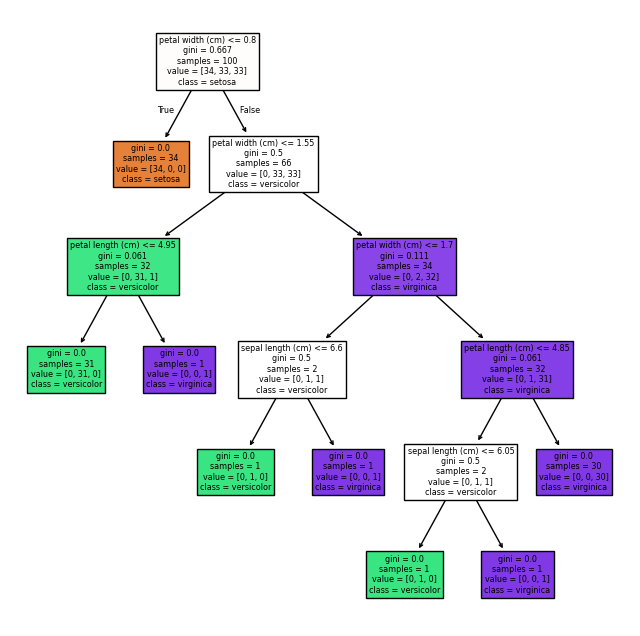

In [62]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

# Instantiate and fit model to data
my_dt = DecisionTreeClassifier()
my_dt.fit(train_x, train_y)

# Show the decision tree
fig, ax = plt.subplots(figsize=(8, 8))
tree.plot_tree(my_dt, feature_names=feature_names, class_names=label_names, filled=True, ax=ax)
plt.show()

### Evaluate the trained model's performance on unseen test data

In [63]:
# Make predictions for test data
predictions = my_dt.predict(test_x)
print(f'Predictions are:\n {predictions}')

# Calculate the accuracy
accuracy = 100 * (test_y == predictions).sum() / test_y.shape[0]
print(f"\nOverall Accuracy = {accuracy:.2f} %")

Predictions are:
 [2 1 0 1 2 1 1 0 1 1 0 0 0 0 0 2 1 1 2 1 2 1 0 2 0 2 2 0 0 2 2 2 0 1 0 0 2
 1 2 1 1 1 0 0 2 1 2 1 1 2]

Overall Accuracy = 94.00 %


### Visualise a confusion matrix

[]

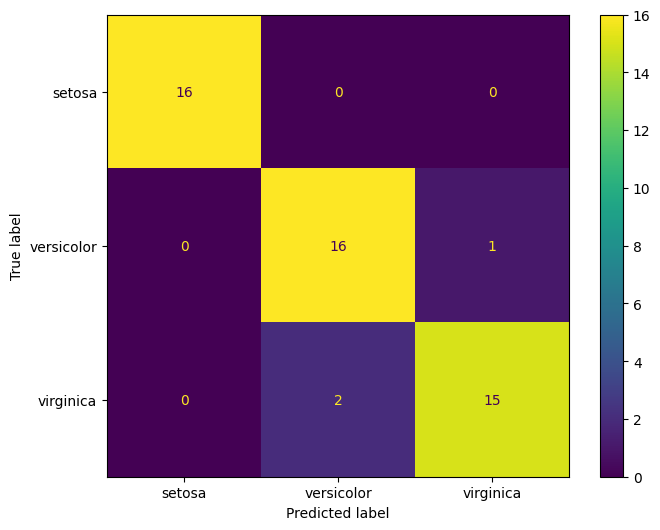

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(test_y, predictions, display_labels=label_names)
disp.figure_.set_size_inches(8, 6)
plt.plot()

### Visualise the decision boundary

Overall Accuracy in 2D = 62.0%, model makes 19 mistakes


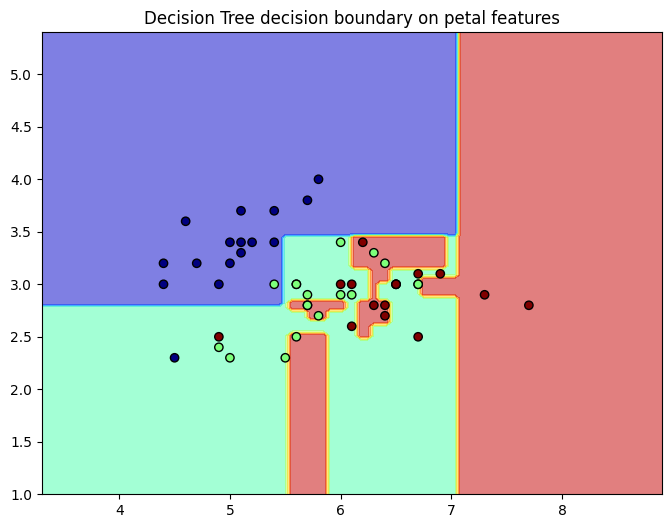

In [64]:
from sklearn.inspection import DecisionBoundaryDisplay

# Make data using numpy slicing to just pull the last two columns for every row
petal_trainx = train_x[:, :2]
petal_testx = test_x[:, :2]

# Instantiate and fit model to data
my_dt_2d = DecisionTreeClassifier()
my_dt_2d.fit(petal_trainx, train_y)

# Make predictions, score them 
y_pred = my_dt_2d.predict(petal_testx)
accuracy = 100 * ( test_y == y_pred).sum() / test_y.shape[0]
num_errors= len(y_pred) - (test_y == y_pred).sum()
print(f"Overall Accuracy in 2D = {accuracy}%, model makes {num_errors} mistakes")

# Create the decision boundary learned by model from training data
disp = DecisionBoundaryDisplay.from_estimator(my_dt_2d, petal_trainx, alpha=0.5)

# # Show where the test is within the decision boundary
disp.ax_.scatter(petal_testx[:, 0], petal_testx[:, 1], c=test_y, edgecolor='black', label='test')
_= disp.ax_.set_title("Decision Tree decision boundary on petal features")
disp.figure_.set_size_inches(8, 6)
plt.show()

<div class="alert alert-block alert-info" style="color:black"><h2>Activity 4: Experiment with Decision Trees</h2>
We often want to control how we learn a model (in this case, grow a tree) to avoid a phenomenon call <i>over-fitting</i>. This is where the model is capturing fine-details of the training set and so failing to generalise from the training set to the real world.

The aim of this activity is for you to experiment with what happens when you change two <b>hyper-parameters</b> that affect how big and complex the tree is allowed to get.
<ul>
    <li><code>max_depth</code>: default is None</li>
    <li><code>min_samples_leaf</code>: default value is 1</li>
</ul>
Experiment with the Iris data set we loaded earlier to see if you can work out what each of these hyper-parameters does, and how it affects the tree. Try running and evaluating KNN with different values for <code>max_depth</code> = {None, 1, 3, 5} and <code>min_samples_leaf</code> = {1, 3, 5}:
    <ul>
        <li>Do some combinations result in bigger differences between accuracy on the train / test sets?</li>
        <li>Is there a combination of hyper-parameter values that means you consistently get similar trees?</li>
        <li>What is a good way of judging 'similarity?</li>
        <li>Do different train/test splits affect what tree you get?</li>
    </ul>
</div>

Training set has 100 examples, test set has 50 examples
Overall Accuracy for depth=None and min_leaf=3 is 86.00%


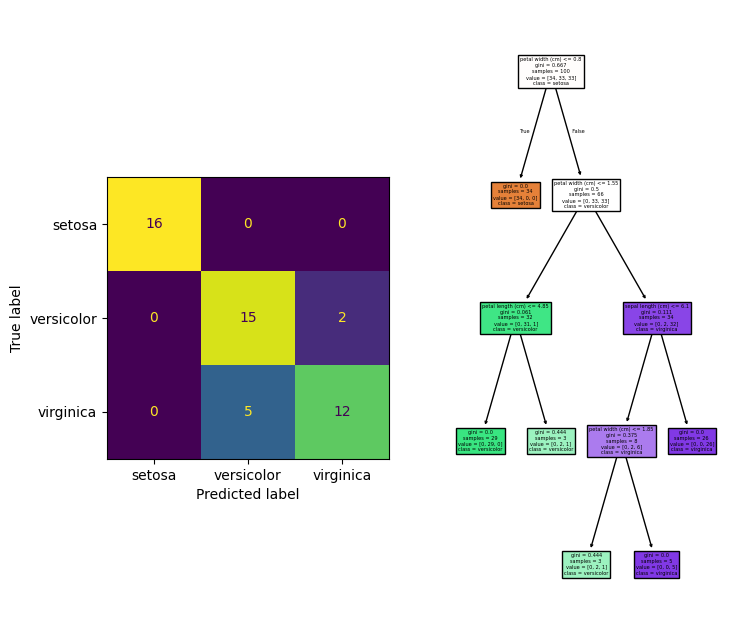

In [66]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.model_selection import train_test_split

# Make train/test split of datasets
train_x, test_x, train_y, test_y = train_test_split(irisX, irisy, test_size=0.33, stratify=irisy, random_state=42)
print(f'Training set has {train_x.shape[0]} examples, test set has {test_x.shape[0]} examples')

# Experiment with changing these values
depth = None  # Try None 1, 3, 5
min_leaf = 3  # Try 1, 3, 5

# Instantiate and fit model to data
my_dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_leaf)
my_dt.fit(train_x, train_y)

# Make predictions
predictions = my_dt.predict(test_x)

# Calculate the accuracy
accuracy = 100 * (test_y == predictions).sum() / test_y.shape[0]
print(f"Overall Accuracy for depth={depth} and min_leaf={min_leaf} is {accuracy:.2f}%")


# Plot the confusion matrix and the tree side by side
fig, ax= plt.subplots(ncols=2, figsize=(8, 8)) 
cm = ConfusionMatrixDisplay.from_predictions(test_y, predictions, display_labels=label_names, colorbar=False, ax=ax[0])
_ = tree.plot_tree(my_dt, feature_names=feature_names, class_names=label_names, filled=True, ax=ax[1])


<div class="alert alert-block alert-success" style="color:black"><b>Save and close Jupyter:</b>
    <ol>
        <li>Use the jupyterlab functions to download your work (ask your tutor if you need help with this) and save it somewhere sensible so you can find it easily.</li>
        <li>Shutdown the notebook when you have finished with this tutorial (menu->file->close and shutdown notebook)</li>
    </ol>
</div